In [1]:
!pip install openpyxl
!pip install wordcloud
!pip install calmap

# Modules for data processing
import pandas as pd
import numpy as np
import os
import re
import sys
from datetime import datetime
import calendar

import warnings
warnings.filterwarnings("ignore")

# REFERENCE: https://www.kaggle.com/dmitryuarov/eda-covid-19-impact-on-digital-learning
STATE_ABBR = {
    'Alabama': 'AL', 'Alaska': 'AK', 'American Samoa': 'AS', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'District of Columbia': 'DC', 'District Of Columbia': 'DC',
    'Florida': 'FL', 'Georgia': 'GA', 'Guam': 'GU', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL',
    'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME',
    'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH',
    'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND',
    'Northern Mariana Islands':'MP', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA',
    'Puerto Rico': 'PR', 'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN',
    'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virgin Islands': 'VI', 'Virginia': 'VA', 'Washington': 'WA',
    'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}
STATE_NAME = dict([(y, x) for x, y in STATE_ABBR.items()])

# ########################################################################
# ### analyze_dataset
# ########################################################################
# #
# # Simple function to help quickly analyze information & usability of
# # a dataset. Provides information about shape, null values, unique
# # values & basic statistical features.
# #
# # Inputs:
# #   1.  df_path (string) -> Dataset path (if available)
# #   2.  df (pandas dataframe) -> Dataset (if available)
# #   3.  direct_df (boolean) -> Whether dataset path or dataset is
# #       being provided
# #   4.  processing_func (function) -> If dataset needs to be processed
# #       before analyzing
# #   5.  Other arguments for pd.read_csv(...) if dataset path is being
# #       provided
# #
# # Return:   Either dataframe itself (if path provided) or head of
# #           dataframe (if dataframe provided)
# #
# ########################################################################

# def analyze_dataset(df_path = None, df = None, direct_df = False, processing_func = lambda x: x, **read_csv_args):
    
#     if(direct_df == False):
#         df = pd.read_csv(df_path, **read_csv_args)
#     df = processing_func(df)
    
#     num_rows, num_cols = df.shape
#     dtypes = dict(df.dtypes.items())
#     print("*****************")
#     print("Basic Info:")
#     print("*****************\n")
#     print(f"Shape of Dataset: {num_rows} rows, {num_cols} cols")
#     print("Columns:")
#     for col_idx, col in enumerate(df.columns):
#         print(f"\t{col_idx+1}. {col}\n\t\t\t\t\t\t\t\t{dtypes[col]}")
    
#     print("\n\n\n*****************")
#     print("Null Values:")
#     print("*****************\n")
#     nulls = pd.isnull(df).sum()
#     print(f"Total Nulls: {nulls.sum()}")
#     nulls = nulls[nulls > 0]
#     nulls = list(sorted(nulls.items(), key = lambda x: x[1], reverse = True))
#     print("Columns with missing values:")
#     for col_idx, (col_name, col_missin_num) in enumerate(nulls):
#         print(f"\t{col_idx + 1}. {col_name}\n\t\t\t\t\t\t\t\t{col_missin_num} missing ({col_missin_num / num_rows * 100:.1f}%)")
    
#     print("\n\n\n*****************")
#     print("Column-specific:")
#     print("*****************\n")
#     print("Unique values in columns:")
#     idx = 1
#     for col in df.columns:
#         nunique = df[col].nunique()
#         if(nunique < 10):
#             unique_vals = ["'" + str(x) + "'" for x in df[col].unique()]
#             print(f"{idx}. {col} has {nunique} unique values")
#             idx += 1
#             print(f"\t[ {', '.join(unique_vals)} ]")
#     print("\n\nStatistical Features:")
#     print(df.describe())
    
#     print("\n\n")
#     if(direct_df == True):
#         return df.head()
#     else:
#         return df

########################################################################
### load_main_dataset
########################################################################
#
# Function to load the main processed & merged dataset for
# engagement. Has options to merge selected datasets. The processing
# has been done separately in another function `process_main_dataset`
#
# Inputs:
#   1.  whether_merge_district (boolean) -> Whether to merge districts
#       data
#   2.  whether_merge_products (boolean) -> Whether to merge products
#       data
#   3.  whether_merge_dates (boolean) -> Whether to merge dates data
#
# Return:   Engagement data merged with other relevant datasets
#
########################################################################

def load_main_dataset(whether_merge_districts = True, whether_merge_products = True, whether_merge_dates = True):
    def reduce_dtype_size(df):
        numeric_cols = [x for x in df.columns if (df[x].dtype != object) & ('datetime' not in str(df[x].dtype))]
        for numeric_col in numeric_cols:
            if('float' in str(df[numeric_col].dtype)):
                df[numeric_col] = pd.to_numeric(df[numeric_col], downcast = 'float')
            elif(('uint' in str(df[numeric_col].dtype)) | ('bool' in str(df[numeric_col].dtype))):
                df[numeric_col] = pd.to_numeric(df[numeric_col], downcast = 'unsigned')
            else:
                df[numeric_col] = pd.to_numeric(df[numeric_col], downcast = 'signed')
        return df
    
    def merge_districts_data(engagement_data):
        districts_data = pd.read_csv('/kaggle/input/learnplatform-analysis-data/districts_data.csv')
        districts_data = reduce_dtype_size(districts_data)
        merged_engagement_data = pd.merge(engagement_data, districts_data, how = 'left', on = 'district_id')
        return merged_engagement_data

    def merge_products_data(engagement_data):
        products_data = pd.read_csv('/kaggle/input/learnplatform-analysis-data/products_data.csv')
        products_data = reduce_dtype_size(products_data)
        merged_engagement_data = pd.merge(engagement_data, products_data, how = 'left', left_on = 'lp_id', right_on = 'LP ID')
        merged_engagement_data = merged_engagement_data.drop('LP ID', axis = 1)
        return merged_engagement_data

    def merge_dates_data(engagement_data):
        dates_data = pd.read_csv('/kaggle/input/learnplatform-analysis-data/dates_data.csv', parse_dates = ['date'])
        dates_data = reduce_dtype_size(dates_data)
        merged_engagement_data = pd.merge(engagement_data, dates_data, how = 'left', left_on = 'time', right_on = 'date')
        merged_engagement_data = merged_engagement_data.drop('date', axis = 1)
        return merged_engagement_data

    engagement_data = pd.read_csv('/kaggle/input/learnplatform-analysis-data/engagement_data.csv', parse_dates = ['time'])
    engagement_data = reduce_dtype_size(engagement_data)
    if(whether_merge_districts == True):
        engagement_data = merge_districts_data(engagement_data)
    if(whether_merge_products == True):
        engagement_data = merge_products_data(engagement_data)
    if(whether_merge_dates == True):
        engagement_data = merge_dates_data(engagement_data)
    
    return engagement_data


# ########################################################################
# ### process_main_dataset
# ########################################################################
# #
# # Function to process the main processed & save it for
# # loading later from another function `load_main_dataset`.
# #
# # Inputs:
# #   1.  whether_load_url_html_data (boolean) -> Whether to process
# #       and save URL's HTML data
# #
# # Return:   None
# #
# ########################################################################

# def process_main_dataset(whether_load_url_html_data = False):
#     def get_all_na_idx(df):
#         all_na_idx = df.isnull().all(axis=1)
#         return all_na_idx[all_na_idx == True].keys()

#     def add_dummys(df, dummy_cols, remove_orig_dummy_cols = False):
#         dummy_df = df[dummy_cols]
#         dummy_df = pd.get_dummies(dummy_df)
        
#         df = pd.concat([df, dummy_df], axis = 1)
#         if(remove_orig_dummy_cols == True):
#             df = df.drop(dummy_cols, axis = 1)
        
#         return df

#     def reduce_dtype_size(df):
#         numeric_cols = [x for x in df.columns if (df[x].dtype != object) & ('datetime' not in str(df[x].dtype))]
#         for numeric_col in numeric_cols:
#             if('float' in str(df[numeric_col].dtype)):
#                 df[numeric_col] = pd.to_numeric(df[numeric_col], downcast = 'float')
#             elif(('uint' in str(df[numeric_col].dtype)) | ('bool' in str(df[numeric_col].dtype))):
#                 df[numeric_col] = pd.to_numeric(df[numeric_col], downcast = 'unsigned')
#             else:
#                 df[numeric_col] = pd.to_numeric(df[numeric_col], downcast = 'signed')
#         return df
    
#     def load_districts_data():
        
#         def districts_data_preprocessing(districts_data):
            
#             def process_lower_upper_bounds(df_series):
#                 processed_lower_series = []
#                 processed_upper_series = []
                
#                 for row in df_series:                
#                     if(pd.isnull(row) == True):
#                         processed_lower_series.append(row)
#                         processed_upper_series.append(row)
#                     else:
#                         assert(len(row[1:-1].split(', ')) == 2)
#                         lower_val, upper_val = row[1:-1].split(', ')
#                         lower_val = float(lower_val)
#                         upper_val = float(upper_val)
#                         processed_lower_series.append(lower_val)
#                         processed_upper_series.append(upper_val)
                
#                 return processed_lower_series, processed_upper_series
            
#             for col in ['pct_black/hispanic', 'pct_free/reduced', 'county_connections_ratio', 'pp_total_raw']:
#                 lower_series, upper_series = process_lower_upper_bounds(districts_data[col])
#                 districts_data[col + '_lower_bound'] = pd.Series(lower_series, index = districts_data.index)
#                 districts_data[col + '_upper_bound'] = pd.Series(upper_series, index = districts_data.index)
#                 districts_data[col + '_bound_avg'] = pd.Series(np.add(lower_series, upper_series) / 2.0, index = districts_data.index)
            
#             districts_data = districts_data.drop(['pct_black/hispanic', 'pct_free/reduced', 'county_connections_ratio', 'pp_total_raw'], axis = 1)
#             return districts_data
        
#         districts_data = pd.read_csv('/kaggle/input/learnplatform-covid19-impact-on-digital-learning/districts_info.csv')
        
#         districts_data = districts_data_preprocessing(districts_data)
#         districts_data = districts_data.drop(get_all_na_idx(districts_data.drop('district_id', axis = 1))).reset_index(drop = True)
#         districts_data = add_dummys(districts_data, ['locale'], remove_orig_dummy_cols = False)
        
#         #all_states = districts_data['state'].unique()
#         #district_id_state_map = dict(districts_data[['district_id', 'state']].values)
#         #state_district_id_map = dict([(x, [y for y in district_id_state_map if district_id_state_map[y] == x]) for x in all_states])
#         #districts_data = districts_data.drop('state', axis = 1)
        
#         districts_data = reduce_dtype_size(districts_data)
#         return districts_data

#     districts_data = load_districts_data()
    
#     # URL Information Extraction
#     #   For July 2021
#     #   Using similarweb.com
#     #   Avg Duration - in seconds
#     #   Total Visits - in 1000s
#     def load_url_html_data():
#         url_html_dict = {}

#         all_html_content = ""
#         with open(f'./Data/url_info/combined_url_info_data.txt', 'r') as html_file:
#             all_html_content = html_file.read()

#         tot_num_files = len([x for x in all_html_content.split('---') if len(x.strip()) != 0])
#         print(f"Total No. of files: {tot_num_files}\n\n")

#         for html_content_idx, html_content in enumerate(all_html_content.split('---')):
            
#             html_content = html_content.strip()
#             if(len(html_content) == 0):
#                 print("ERROR: URL not found")
#                 sys.exit("")
            
#             url_name = html_content.split('<')[0].strip()
#             html_content = '<'.join(html_content.split('<')[1:])
#             print(f"{html_content_idx + 1}. File: {url_name}\n")
#             if(url_name in url_html_dict):
#                 print("ERROR: Name already exists")
#                 sys.exit("")
#             url_html_dict[url_name] = {}
            
#             # Global Rank
#             global_rank = re.findall('\"GlobalRank":\[\d+,\d+,-?\d+,\d+\]', html_content)
#             if(len(global_rank) != 1):
#                 print("ERROR: Global Rank")
#                 print(global_rank)
#                 sys.exit("")
#             global_rank = int(global_rank[0].split('[')[1].split(',')[0])
#             url_html_dict[url_name]['global_rank'] = global_rank

#             # Country
#             if('<img class="websiteRanks-titleIconImg" src="/images/flags-svg/flag-icon-us.svg">' in html_content):
#                 country = 'USA'
#             else:
#                 print("Country: Not USA!")
#                 country = 'Not_USA'
#             url_html_dict[url_name]['country'] = country
            
#             # Country Rank
#             country_rank = re.findall('\"CountryRanks":\{"\d+":\[\d+,\d+,-?\d+,\d+\]\}', html_content)
#             if(len(country_rank) != 1):
#                 print("ERROR: Country Rank")
#                 print(country_rank)
#                 sys.exit("")
#             country_rank = int(country_rank[0].split('[')[1].split(',')[0])
#             url_html_dict[url_name]['country_rank'] = country_rank
            
#             # Category
#             category = re.findall('<a class="websiteRanks-nameText" data-analytics-category="Internal Link" data-analytics-label="Category Rank/.+" href="/top-websites/category/.+" itemprop="significantLink">.+</a>', html_content)
#             if(len(category) != 1):
#                 print("ERROR: Category")
#                 print(category)
#                 url_html_dict[url_name]['main_category'] = np.nan
#                 url_html_dict[url_name]['sub_category'] = np.nan
#             else:
#                 category = category[0].split('Category Rank/')[1].split('"')[0]
#                 main_category = category.split('/')[0]
#                 url_html_dict[url_name]['main_category'] = main_category
#                 if(len(category.split('/')) != 1):
#                     sub_category = category.split('/')[-1]
#                 else:
#                     sub_category = ""
#                 url_html_dict[url_name]['sub_category'] = sub_category

#             # Category Rank
#             category_rank = re.findall('\"CategoryRank\":\[\d+,\d+,-?\d+,\d+\]', html_content)
#             if(len(category_rank) != 1):
#                 print("ERROR: Category Rank")
#                 print(category_rank)
#                 sys.exit("")
#             category_rank = int(category_rank[0].split('[')[1].split(',')[0])
#             url_html_dict[url_name]['category_rank'] = category_rank

#             # Total Visits
#             total_visits = re.findall('<span class="engagementInfo-valueNumber js-countValue">.*\d+[KMB]</span>', html_content)
#             if(len(total_visits) != 1):
#                 print("ERROR: Total Visits")
#                 print(total_visits)
#                 url_html_dict[url_name]['total_visits'] = np.nan
#             else:
#                 total_visits = total_visits[0].split('>')[1].split('<')[0]
#                 units = total_visits[-1]
#                 total_visits = float(''.join([x for x in total_visits if x.isdigit()]))
#                 if(units == 'K'):
#                     total_visits = total_visits * 1
#                 elif(units == 'M'):
#                     total_visits = total_visits * 1000
#                 elif(units == 'B'):
#                     total_visits = total_visits * 1000000
#                 url_html_dict[url_name]['total_visits'] = total_visits

#             # Avg Duration
#             avg_duration = re.findall('<span class="engagementInfo-valueNumber js-countValue">\d+:\d+:\d+</span>', html_content)
#             if(len(avg_duration) != 1):
#                 print("ERROR: Avg Duration")
#                 print(avg_duration)
#                 url_html_dict[url_name]['avg_duration'] = np.nan
#             else:
#                 avg_duration = avg_duration[0].split('>')[1].split('<')[0]
#                 hr_val, min_val, sec_val = avg_duration.split(':')
#                 avg_duration = 3600 * int(hr_val) + 60 * int(min_val) + int(sec_val)
#                 url_html_dict[url_name]['avg_duration'] = avg_duration

#             # Page Visits
#             page_visits = re.findall('<span class="engagementInfo-valueNumber js-countValue">\d+\.\d+</span>', html_content)
#             if(len(page_visits) != 1):
#                 print("ERROR: Page Visits")
#                 print(page_visits)
#                 url_html_dict[url_name]['page_visits'] = np.nan
#             else:
#                 page_visits = float(page_visits[0].split('>')[1].split('<')[0])
#                 url_html_dict[url_name]['page_visits'] = page_visits

#             # Bounce Rate
#             bounce_rate = re.findall('<span class="engagementInfo-valueNumber js-countValue">\d+.\d+%</span>', html_content)
#             if(len(bounce_rate) != 1):
#                 print("ERROR: Bounce Rate")
#                 print(bounce_rate)
#                 url_html_dict[url_name]['bounce_rate'] = np.nan
#             else:
#                 bounce_rate = float(bounce_rate[0].split('>')[1].split('%')[0])
#                 url_html_dict[url_name]['bounce_rate'] = bounce_rate
            
#             # Description
#             description = re.findall('<p itemprop="description" class="websiteHeader-companyDescription js-companyDescription">.+</p>', html_content)
#             if(len(description) != 1):
#                 url_html_dict[url_name]['description'] = np.nan
#             else:
#                 description = description[0].split('>')[1].split('<')[0]
#                 url_html_dict[url_name]['description'] = description

#         url_html_df = pd.DataFrame.from_dict(url_html_dict, orient = 'index').reset_index(drop = False)
#         url_html_df.columns = ['URL'] + [*url_html_df.columns][1:]

#         url_html_df['global_rank'] = url_html_df['global_rank'].replace({0: np.nan})
#         url_html_df['country_rank'] = url_html_df['country_rank'].replace({0: np.nan})
#         url_html_df['category_rank'] = url_html_df['category_rank'].replace({0: np.nan})

#         additional_data = pd.read_csv('./Data/url_info/url_info_mobile.csv')
#         url_html_df = pd.concat([url_html_df, additional_data], axis = 0)

#         def find_subpage_level(url):
#             level = url.split('://')[1]
#             level = level.split('/')
#             level = [x for x in level if len(x.strip()) > 0]
#             return len(level) - 1
#         url_html_df['URL_subpage_level'] = url_html_df['URL'].apply(find_subpage_level)
#         url_html_df['URL_subpage_visits'] = url_html_df.apply(lambda x: x['total_visits'] * (((100 - x['bounce_rate']) / 100) ** x['URL_subpage_level']), axis = 1)
#         url_html_df['URL_page_duration'] = url_html_df['avg_duration'] / url_html_df['page_visits']
#         url_html_df['URL_subpage_total_browsing_days'] = url_html_df['URL_subpage_visits'] * url_html_df['URL_page_duration'] / 60 / 60 / 24
#         url_html_df['URL_subpage_avg_browsing_days'] = url_html_df['URL_subpage_total_browsing_days'] / 31
#         url_html_df.to_csv('./Data/url_info/final_url_data.csv', index = False)
    
#     def load_products_data():
    
#         def products_data_preprocessing(products_data):

#             products_data['Primary Category'] = products_data['Primary Essential Function'].apply(lambda x: x.split(' - ')[0] if pd.isna(x) == False else np.nan)
#             products_data['Primary Category'] = products_data['Primary Category'].map({'LC': 'LC', 'CM': 'CM', 'SDO': 'SDO', 'LC/CM/SDO': 'Other'})
#             products_data['Primary Essential Function'] = products_data['Primary Essential Function'].apply(lambda x: x.split(' - ')[1] if pd.isna(x) == False else np.nan)
            
#             def sector_map(sectors):
                
#                 sector_prek12 = []
#                 sector_higher_ed = []
#                 sector_corporate = []
                
#                 for sector in sectors:
#                     if(pd.isna(sector) == True):
#                         sector_prek12.append(0)
#                         sector_higher_ed.append(0)
#                         sector_corporate.append(0)
#                     elif(sector == 'PreK-12'):
#                         sector_prek12.append(1)
#                         sector_higher_ed.append(0)
#                         sector_corporate.append(0)
#                     elif(sector == 'PreK-12; Higher Ed'):
#                         sector_prek12.append(1)
#                         sector_higher_ed.append(1)
#                         sector_corporate.append(0)
#                     elif(sector == 'PreK-12; Higher Ed; Corporate'):
#                         sector_prek12.append(1)
#                         sector_higher_ed.append(1)
#                         sector_corporate.append(1)
#                     elif(sector == 'Corporate'):
#                         sector_prek12.append(0)
#                         sector_higher_ed.append(0)
#                         sector_corporate.append(1)
#                     elif(sector == 'Higher Ed; Corporate'):
#                         sector_prek12.append(0)
#                         sector_higher_ed.append(1)
#                         sector_corporate.append(1)
#                     else:
#                         print(f"***\nUnknown sector detected! {sector}\n***")
                
#                 return sector_prek12, sector_higher_ed, sector_corporate
            
#             sector_prek12, sector_higher_ed, sector_corporate = sector_map(products_data['Sector(s)'])
#             products_data = products_data.assign(Sector_prek12 = sector_prek12)
#             products_data = products_data.assign(Sector_higher_ed = sector_higher_ed)
#             products_data = products_data.assign(Sector_corporate = sector_corporate)
            
#             products_data['Primary Essential Function'] = products_data['Primary Essential Function'].replace({"Sites, Resources & References": "Sites, Resources & Reference"})
            
#             # Correcting small mistakes
#             products_data['URL'] = products_data['URL'].replace({'https://fligprid.com': 'https://flipgrid.com'})

#             if(whether_load_url_html_data == True):
#                 load_url_html_data()
#             url_info_data = pd.read_csv('./Data/url_info/final_url_data.csv')
#             url_info_data.columns = ['mainURL_' + x if x != 'URL' else x for x in url_info_data.columns]
#             products_data = pd.merge(products_data, url_info_data, how = 'left', on = 'URL')
            
#             products_data['mainURL_country_rank'] = products_data.apply(lambda x: x if x['mainURL_country'] == 'USA' else np.nan, axis = 1)
            
#             return products_data
        
#         products_data = pd.read_csv('./Data/learnplatform-covid19-impact-on-digital-learning/products_info.csv')
        
#         products_data = products_data_preprocessing(products_data)
#         products_data = add_dummys(products_data, ['Sector(s)', 'Primary Category', 'Primary Essential Function', 'mainURL_main_category'], remove_orig_dummy_cols = False)
        
#         products_data = reduce_dtype_size(products_data)
#         return products_data

#     products_data = load_products_data()

#     # Not focusing on vacation dates since time-analysis is not priority

#     def load_dates_data():
#         days_2020 = pd.date_range(datetime(2020, 1, 1), datetime(2020, 12, 31))
#         dates_data = pd.DataFrame.from_dict({'date': days_2020})
        
#         dates_data['month'] = dates_data['date'].apply(lambda x: x.month)
#         dates_data['day'] = dates_data['date'].apply(lambda x: x.day)
#         dates_data['day_of_week'] = dates_data['date'].apply(lambda x: calendar.day_name[x.weekday()])
#         dates_data['is_weekend'] = dates_data['day_of_week'].apply(lambda x: 1 if (x == 'Saturday') | (x == 'Sunday') else 0)
        
#         us_holidays = pd.read_csv('./Data/US Holiday Dates (2004-2021).csv', usecols = ['Date', 'Holiday'], parse_dates = ['Date'])
#         dates_data = pd.merge(dates_data, us_holidays, how = 'left', left_on = 'date', right_on = 'Date')
#         dates_data = dates_data.drop('Date', axis = 1)
#         dates_data['is_holiday'] = dates_data['Holiday'].apply(lambda x: 0 if pd.isnull(x) == True else 1)
        
#         dates_data = add_dummys(dates_data, ['day_of_week', 'Holiday'], remove_orig_dummy_cols = False)
#         dates_data = reduce_dtype_size(dates_data)
#         return dates_data

#     dates_data = load_dates_data()

#     def load_engagement_data():

#         engagement_data = pd.DataFrame()
#         districts = []
        
#         for x in os.listdir('./Data/learnplatform-covid19-impact-on-digital-learning/engagement_data/'):
#             data_x = pd.read_csv(f'./Data/learnplatform-covid19-impact-on-digital-learning/engagement_data/{x}', parse_dates = ['time'])
#             engagement_data = pd.concat([engagement_data, data_x], axis = 0)
#             districts.extend([int(x.split('.')[0])] * data_x.shape[0])
        
#         engagement_data['district_id'] = pd.Series(districts, index = engagement_data.index)
        
#         top_products_id = list(products_data['LP ID'].unique())
#         districts_id = list(districts_data['district_id'].unique())
#         engagement_data = engagement_data[engagement_data['lp_id'].isin(top_products_id)]
#         engagement_data = engagement_data[engagement_data['district_id'].isin(districts_id)]
        
#         same_url_map = {
#             33562: 75206,
#             87841: 35971
#         }
#         engagement_data['lp_id'] = engagement_data['lp_id'].replace(same_url_map)
#         engagement_data = engagement_data.groupby(['time', 'lp_id', 'district_id'])[['pct_access', 'engagement_index']].aggregate(np.nansum).reset_index()
        
#         engagement_data = reduce_dtype_size(engagement_data)
#         return engagement_data

#     engagement_data = load_engagement_data()

#     # # Saving all datasets
#     districts_data.to_csv('./Data/Processed_Dataset/districts_data.csv', index = False)
#     products_data.to_csv('./Data/Processed_Dataset/products_data.csv', index = False)
#     dates_data.to_csv('./Data/Processed_Dataset/dates_data.csv', index = False)
#     engagement_data.to_csv('./Data/Processed_Dataset/engagement_data.csv', index = False)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

COLOR_WHITE = '#F8F1FF'
COLOR_BLACK = '#231942'
COLOR_DARK_BLUE = '#156BB7'
COLOR_LIGHT_BLUE = '#63D1DF'
COLOR_GREEN = '#30DB8D'
COLOR_DARK_GREEN = '#0DAB6C'
COLOR_ORANGE = '#FBAB60'
COLOR_YELLOW = '#F8E16C'
COLOR_RED = '#DA4167'

PLOT_THEME_LIGHT = {
    'text': COLOR_BLACK,
    'axis': COLOR_BLACK,
    'subtitle': COLOR_DARK_BLUE,
    'color+1': COLOR_DARK_GREEN,
    'color+2': COLOR_YELLOW,
    'color+3': COLOR_ORANGE,
    'color+4': COLOR_DARK_BLUE,
    'color-1': COLOR_RED,
    'bg': COLOR_LIGHT_BLUE,
    'inv': COLOR_WHITE,
    'color+1_lower': '#064B30',
    'color+1_higher': '#2EEFA2',
    'gray': '#676076',
}
PLOT_THEME_LIGHT['groups'] = [PLOT_THEME_LIGHT[x] for x in ['color+1', 'color-1', 'color+3', 'color+4', 'color+2']]

PLOT_THEME_DARK = {
    'text': COLOR_WHITE,
    'axis': COLOR_WHITE,
    'subtitle': COLOR_LIGHT_BLUE,
    'color+1': COLOR_GREEN,
    'color+2': COLOR_YELLOW,
    'color+3': COLOR_ORANGE,
    'color+4': COLOR_LIGHT_BLUE,
    'color-1': COLOR_RED,
    'bg': COLOR_DARK_BLUE,
    'inv': COLOR_BLACK,
    'color+1_lower': '#188B57',
    'color+1_higher': '#86EABD',
    'gray': '#D6CFDB',
}
PLOT_THEME_DARK['groups'] = [PLOT_THEME_DARK[x] for x in ['color+1', 'color-1', 'color+3', 'color+4', 'color+2']]

def create_fig(nrows = 1, ncols = 1, width = 10, height = 5):
    fig, ax = plt.subplots(nrows, ncols, figsize = (width, height))
    return fig, ax

def remove_spines(ax, theme = {}):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color(theme['axis'])
    ax.spines['left'].set_color(theme['axis'])
    return ax

def remove_all_spines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return ax

def set_titles_and_labels(fig, ax, fig_title = "", title = "", xlabel = "", ylabel = "", theme = {}):
    fig.suptitle(fig_title, fontsize = 30, color = theme['text'])
    ax.set_title(title, fontsize = 20, color = theme['subtitle'])
    ax.set_xlabel(xlabel, fontsize = 15, color = theme['text'])
    ax.set_ylabel(ylabel, fontsize = 15, color = theme['text'])
    return fig, ax

def set_ticks(ax, theme):
    ax.tick_params(axis = 'x', colors = theme['axis'])
    ax.tick_params(axis = 'y', colors = theme['axis'])
    return ax

def set_xticklabels(ax, labels, rotate_x = 0, theme = {}):
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, color = theme['text'], rotation = rotate_x)
    return ax

def set_yticklabels(ax, labels, rotate_y = 0, theme = {}):
    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels(labels, color = theme['text'], rotation = rotate_y)
    return ax

def set_bg(fig, ax, theme):
    fig.set_facecolor(theme['bg'])
    ax.set_facecolor(theme['bg'])
    return fig, ax

def select_theme(theme):
    if(theme == 'DARK'):
        return PLOT_THEME_DARK
    else:
        return PLOT_THEME_LIGHT

def set_legend(ax, theme):
    ax.legend(loc = 'best')
    return ax

def plot_decoration():
    return """
    fig, ax = set_bg(fig, ax, theme); ax = set_ticks(ax, theme); ax = remove_spines(ax, theme); fig, ax = set_titles_and_labels(fig, ax, suptitle, title, xlabel, ylabel, theme);
    """.strip()

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_lineplot(x_vals, y_vals, width = 15, height = 7, labels = [], suptitle = "Lineplot", title = "Demo", xlabel = "", ylabel = "", theme = 'DARK'):
    theme = select_theme(theme)
    fig, ax = create_fig(1, 1, width, height)
    if(len(y_vals) > len(theme['groups'])):
        group_colors = [(np.random.random(), np.random.random(), np.random.random()) for _ in range(len(y_vals))]
    else:
        group_colors = theme['groups'][:len(y_vals)]
    for y_val_idx, y_val in enumerate(y_vals):
        if(len(labels) == 0):
            ax.plot(x_vals, y_val, lw = 3, color = group_colors[y_val_idx], label = f'line #{y_val_idx + 1}')
        else:
            ax.plot(x_vals, y_val, lw = 3, color = group_colors[y_val_idx], label = labels[y_val_idx])
    ax = set_legend(ax, theme)
    exec(plot_decoration())
    plt.show()

def plot_barplot(x_names, y_vals, cats = [], width = 15, height = 7, suptitle = "Barplot", title = "Demo", xlabel = '', ylabel = '', theme = 'DARK', rotate_x = 0, rotate_y = 0):
    theme = select_theme(theme)
    fig, ax = create_fig(1, 1, width, height)
    x_vals = np.arange(len(x_names))
    if(len(cats) > 0):
        uniq_cats = list(sorted(pd.Series(cats).unique()))
        if(len(uniq_cats) > len(theme['groups'])):
            group_colors = [(np.random.random(), np.random.random(), np.random.random()) for _ in range(len(uniq_cats))]
        else:
            group_colors = theme['groups'][:len(uniq_cats)]
        group_colors = [group_colors[uniq_cats.index(x)] for x in cats]
    else:
        if(len(y_vals) > len(theme['groups'])):
            group_colors = [(np.random.random(), np.random.random(), np.random.random()) for _ in range(len(y_vals))]
        else:
            group_colors = theme['groups'][:len(y_vals)]
    ax.bar(x_vals, y_vals, color = group_colors)
    ax = set_xticklabels(ax, x_names, rotate_x = rotate_x, theme = theme)
    exec(plot_decoration())
    plt.show()

def plot_scatterplot(x_vals, y_vals, cats = [1], width = 15, height = 7, suptitle = "Scatterplot", title = 'Demo', xlabel = '', ylabel = '', theme = 'DARK', annotate = False, annotate_texts = []):
    theme = select_theme(theme)
    fig, ax = create_fig(1, 1, width, height)
    no_cats_passed = False
    if(len(cats) == 1):
        cats = np.ones(len(x_vals))
        no_cats_passed = True
    uniq_cats = pd.Series(cats).unique()
    if(len(uniq_cats) > len(theme['groups'])):
        group_colors = [(np.random.random(), np.random.random(), np.random.random()) for _ in range(len(uniq_cats))]
    else:
        group_colors = theme['groups'][:len(uniq_cats)]
    for cat_idx, cat in enumerate(uniq_cats):
        ax.scatter(x_vals[cats == cat], y_vals[cats == cat], color = group_colors[cat_idx], label = cat)
    if(annotate == True):
        for idx in range(len(x_vals)):
            ax.annotate(annotate_texts[idx], (x_vals[idx], y_vals[idx]), color = theme['text'])
    if(no_cats_passed == False):
        ax = set_legend(ax, theme)
    exec(plot_decoration())
    plt.show()

def plot_us_map(state_vals_df, title, val_col, val_label, range_min_val = 0, range_max_val = 1, theme = 'DARK', state_col = 'STATE_ABBR'):
    
    theme = select_theme(theme)

    layout = dict(
        font_family = 'Source Sans Pro',
        font_color = theme['text'],
        title_text = title,
        # To change
        title_font = dict(
            family = "Source Sans Pro",
            size = 25,
            color = theme['axis']
        ),
        geo_scope = 'usa',
        paper_bgcolor = theme['bg'],
        geo_bgcolor = theme['bg'],
        geo = dict(
            landcolor = theme['inv'],
            subunitcolor = theme['gray'],
            lakecolor = theme['bg'],
        ),
    )

    fig = px.choropleth(
        state_vals_df,
        locations = state_col,
        color = val_col,
        color_continuous_scale = [theme['color+1_lower'], theme['color+1_higher']],
        range_color = (range_min_val, range_max_val),
        locationmode = "USA-states",
        labels = {val_col : val_label, state_col: 'State'},
    )

    fig.update_layout(layout)
    fig.update_layout(margin = {"r": 0, "l": 0, "b": 15})
    fig.show()
    
DATA = load_main_dataset()

     |████████████████████████████████| 242 kB 270 kB/s 


<div align='center'>
    <font size='+3' color='#75D345'>
        <b>A Day of Digital Learning</b>
    </font>
    <br>
    <font size='+2.5' color='#FBAB60'>
        <b>Part 1: Wake Up!</b>
    </font>
    <br>
    <br>
    <a href="https://www.kaggle.com/sakshatrao/a-day-of-digital-learning-part-1-wake-up">
        <font size='+1'>
            <b>&#9202; Wake Up!</b>
        </font>
    </a>
    &emsp;|&emsp;
    <a href="https://www.kaggle.com/sakshatrao/a-day-of-digital-learning-part-2-morning-mania">
        <font size='+1'>
            &#127748; Morning Mania
        </font>
    </a>
    &emsp;|&emsp;
    <a href="https://www.kaggle.com/sakshatrao/a-day-of-digital-learning-part-3-sleepy-noons">
        <font size='+1'>
            &#127774; Sleepy Noons
        </font>
    </a>
    &emsp;|&emsp;
    <a href="https://www.kaggle.com/sakshatrao/a-day-of-digital-learning-part-4-finally-done">
        <font size='+1'>
            &#127769; Finally Done!
        </font>
    </a>
</div>

<div style="background-color: #F8F1FF; padding: 20px 50px;">
<span style="color:#156BB7;">
<font size='+2.5'>
    <b>7 AM:</b>
</font>
<br>
<br>
<font size='+1.5'>
    As Grace sleeps in her bedroom, readying herself for another hectic day of online classes, let us also ready ourselves for today. Allow me to set the context.
    <br><br>
    I am a data analyst for a company involved in the education sector and Grace is my lovely 12-year old daughter. Over the past year, both of us have had to share my bedroom for our respective work - she attends her online class while I work on my project. The latest project I am working on involves analyzing the current state of digital education.
    <br><br>
    Spending most of my day with her has been a delightful experience. Her innocent curiosity have made our conversations very engaging and inspiring. Her simple questions & experiences have often helped me come up with innovative ideas for my work. Hopefully, today will be no different.
</font>
</span>
</div>

<div style="background-color: #F8F1FF; padding: 20px 50px;">
<span style="color:#156BB7;">
<font size='+2.5'>
    <b>7:30 AM:</b>
</font>
<br>
<br>
<font size='+1.5'>
    Oh no," Grace said coming out of the bathroom with a toothbrush in her mouth. Still in her Pokemon night gown, her eyes were barely open and her hair was frizzier than ever. "<b>Maths</b> is the first class today," she sighed.
    <br><br>
    "What's wrong with Maths?" I asked.
<br><br>
    "It's pointless!" she replied with a visible irritation on her face. "I want to be an actress," she continued. "Or a photographer, or maybe even a blogger, but you don't need to learn Maths for that! Then why should I learn Maths?"
</font>
</span>
</div>

<div>
<font size='+1'>
    As a data analyst, that seemed a little insulting to me. Sure, an actress or blogger might not need Maths directly; but my entire work is dependent on Maths. My company's services depend on Maths. To be fair, data analysis depends a lot on Maths.
    <br><br>
    But more importantly, Maths is not only useful for data analysts but also for each and every kind of business-owner. Critical decisions regarding expansion, marketing, recruitment, testing and many more are now being data-centered and involve several mathematical tools to recognize patterns, identify relationships and develop insights. Through Maths, one can be more assured about the benefits & risks of future decisions.
    <br><br>
    Take <font color='#FD7121'>LearnPlatform</font> for example. They strive towards developing an <b>EdTech Effectiveness System</b> where one of their main objectives is to build a safer, more equitable and effective EdTech ecosystem based on evidence. In simpler words, they help K-12 districts & Charter Networks in investing efficiently in EdTech products for their students & teachers. Through the use of extensive statistical analysis, they can help in understanding a district's EdTech habits, improve EdTech management and help in making data-informed budget decisions.
    <br><br>
    Not only this, but LearnPlatform provides much more for education agencies & education technology providers. Take a look at this 100-second video for an overview of their useful services -
</font>
</div>

In [2]:
# Video : 640 x 350
from IPython.display import HTML
display(HTML('<div align="center"><iframe width="640" height="350" src="https://www.youtube.com/embed/Fy19PNEXe1M" title="YouTube video player" frameborder="0" allow="accelerometer; encrypted-media; gyroscope"></iframe></div>'))

<div>
<font size='+1'>
    Before moving any further, let me summarize the project that I'm currently working on. The essential idea is to understand the different trends & patterns in Digital Learning, which has become extremely important to understand due to the ongoing pandemic. The most important aspect of the data that I have been provided is Student Engagement which has been represented by two metrics - pct_access & engagement_index.
    <br><br>
    The data can be quickly represented by two interesting visualizations -
</font>
</div>

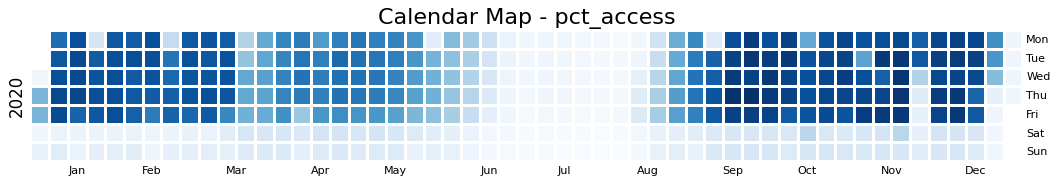

In [3]:
import numpy as np
import pandas as pd
import os
import re
import sys
import time

import matplotlib.pyplot as plt
import matplotlib as mpl
import calmap

engagement_data = DATA.groupby('time')[['pct_access', 'engagement_index']].aggregate(np.nanmean)

fig, ax = plt.subplots(1, 1, figsize=(16,10), dpi= 80)
ax = calmap.yearplot(engagement_data['pct_access'], year = 2020, cmap = 'Blues', ax = ax)
ax.set_title("Calendar Map - pct_access", fontsize = 20)
ax.set_ylabel("2020", fontsize = 15)
plt.show()

<div>
<font size='+1'>
    The Calendar Map, in my opinion, is an outstanding tool to represent the student engagement data. Through this simple plot, several basic inferences can be easily made. Some of them include -
    <ul>
        <li>Student Engagement is much reduced during weekends</li>
        <li>There is a drop in Student Engagement between June & August due to vacations</li>
        <li>Student Engagement decreases from March onwards till the vacations end, after which it reaches very high values after September</li>
        <li>It can also be seen that Student Engagement descreases on Holidays like Labour Day (Sept 7, Monday), Thanksgiving Eve/Day (Nov 25-26, Wednesday-Thursday) & Martin Luther King, Jr. Day (Jan 20, Monday)</li>
    </ul>
    <b>So much information from just one graph!</b>
</font>
</div>

In [4]:
engagement_data = DATA.groupby(['state', 'month'])[['pct_access', 'engagement_index']].aggregate(np.nanmean).reset_index(drop = False)
engagement_data['state'] = engagement_data['state'].replace(STATE_ABBR)

state_vals_df = engagement_data.copy()
title = "Student Engagement - Statewise Timeline"
val_col = "pct_access"
val_label = "% Access"
range_min_val = 0
range_max_val = 1
theme = 'DARK'

# state_vals_df = covid19_severity_data
# title = "Covid Severity"
# val_col = "ConfirmedCases"
# val_label = "Confirmed Cases"
# range_min_val = 1500
# range_max_val = 2500000
# theme = 'DARK'

state_vals_df['month'] = state_vals_df['month'].apply(lambda x: ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'][x - 1])

theme = select_theme(theme)

layout = dict(
    font_family = 'Source Sans Pro',
    font_color = theme['text'],
    title_text = title,
    # To change
    title_font = dict(
        family = "Source Sans Pro",
        size = 25,
        color = theme['axis']
    ),
    geo_scope = 'usa',
    paper_bgcolor = theme['bg'],
    geo_bgcolor = theme['bg'],
    geo = dict(
        landcolor = theme['inv'],
        subunitcolor = theme['gray'],
        lakecolor = theme['bg'],
    ),
)

fig = px.choropleth(
    state_vals_df,
    locations = 'state',
    color = val_col,
    color_continuous_scale = [theme['color-1'], theme['color+1_higher']],
    range_color = (range_min_val, range_max_val),
    locationmode = "USA-states",
    labels = {val_col : val_label, 'state': 'State'},
    animation_frame = 'month'
)

fig.update_layout(layout)
fig.update_layout(margin = {"r": 0, "l": 0, "b": 15})
fig.show()

<div>
<font size='+1'>
    The Student Engagement data is also provided for different counties. However, the county names have been de-identified, making it extremely difficult to work with them. Hence, much of my analysis will be done at the state-level. Maps like above help in understanding the distribution of the Student Engagement data over the different states of the USA. Adding a timeline slider helps in providing a bigger picture with respect to both state & time.
    <br><br>
    For more information about the provided data, visit <a href=https://www.kaggle.com/c/learnplatform-covid19-impact-on-digital-learning/data>the official competition page</a>.
</font>
</div>

<div>
<font size='+1'>
    That should be a sufficient introduction to the context of my analysis. Let us see how the rest of the day unfolds...
</font>
</div>

<div align='center'>
    <font size='+2' color='#75D345'>
        <a style="background-color:#63D1DF; padding: 15px;" href='https://www.kaggle.com/sakshatrao/a-day-of-digital-learning-part-2-morning-mania' target="_blank">Next: <b>Morning Mania</b></a>
    </font>
</div>